Group and sum by metaprogram problem solved with: https://stackoverflow.com/questions/39650749/group-by-sparse-matrix-in-scipy-and-return-a-matrix

#### Load modules

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os

import scanpy as sc
import squidpy as sq

import scipy

from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [35]:
directory = '/n/scratch/users/s/sad167/EPN/Xenium/analysis/neighborhood/all_programs'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
# sample BT1717 was excluded because it was creating problems during metaprogram annotation, and it has extremely high number of cells that confounds the results
samples = ['BT2126', '7EP41', '3EP8', '7EP1', 'BT775', 'BT1717', 'BT2169', 'BT1804', '11EP22',  'BT1743']

path = ['/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231020__200939__BT2126_BT1745/output-XETG00083__0010652__Region_4__20231020__201259',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231102__215055__7EP1_7EP41_3EP8/output-XETG00083__0010575__Region_3__20231102__215155',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231102__215055__7EP1_7EP41_3EP8/output-XETG00083__0010619__Region_3__20231102__215155',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231102__215055__7EP1_7EP41_3EP8/output-XETG00083__0010619__Region_5__20231102__215155',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231107__203958__BT1717_BT775/0010501-Region_2',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231107__203958__BT1717_BT775/0010814-Region_2',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231109__203408__BT1804_BT2169/output-XETG00083__0010498__Region_1__20231109__203421',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231109__203408__BT1804_BT2169/output-XETG00083__0010775__Region_1__20231109__203421',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231208__193657__3EP8_BT1743_7EP1_11EP22_7EP41/output-XETG00083__0010540__Region_1__20231208__193752',
        '/n/scratch/users/s/sad167/EPN/Xenium/data/raw_data/20231208__193657__3EP8_BT1743_7EP1_11EP22_7EP41/output-XETG00083__0010553__Region_3__20231208__193752']

metadata = ['/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231020__200939__BT2126_BT1745/data/individual/cell_ID_0010652-Region_4.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231102__215055__7EP1_7EP41_3EP8/data/individual/cell_ID_0010575-Region_3.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231102__215055__7EP1_7EP41_3EP8/data/individual/cell_ID_0010619-Region_3.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231102__215055__7EP1_7EP41_3EP8/data/individual/cell_ID_0010619-Region_5.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231107__203958__BT1717_BT775/data/individual/cell_ID_0010501-Region_2.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231107__203958__BT1717_BT775/data/individual/cell_ID_0010814-Region_2.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231109__203408__BT1804_BT2169/data/individual/cell_ID_0010498-Region_1.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231109__203408__BT1804_BT2169/data/individual/cell_ID_0010775-Region_1.csv',
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231208__193657__3EP8_BT1743_7EP1_11EP22_7EP41/data/individual/cell_ID_0010540-Region_1.csv',            
            '/n/scratch/users/s/sad167/EPN/Xenium/analysis/20231208__193657__3EP8_BT1743_7EP1_11EP22_7EP41/data/individual/cell_ID_0010553-Region_3.csv']


anndata_list = []
for i in range(len(samples)):
    adata = sc.read_10x_h5(filename = path[i]+'/cell_feature_matrix.h5')
    df = pd.read_csv(path[i]+'/cells.csv.gz')
    
    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()
    
    #adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
    adata.obsm["spatial"] = np.array([adata.obs.x_centroid*0.325, adata.obs.y_centroid*0.325]).transpose().astype('float64')
    
    anno = pd.read_csv(metadata[i], index_col = 0)
    if 'X' in anno.columns:
        anno.index = anno['X']
    
    adata = adata[anno.index,:]
    
    adata.obs['Metaprogram'] = anno['group']
    adata.obs['Metaprogram'] = adata.obs['Metaprogram'].astype('category')
    adata.obs['sample'] = samples[i]
    
    anndata_list.append(adata)
    
    print(samples[i])

adata = sc.concat(anndata_list)

BT2126
7EP41
3EP8
7EP1
BT775
BT1717
BT2169
BT1804
11EP22
BT1743


In [4]:
# Subset to remove "Unassigned" program and oligodendrocytes (too little cell number)
adata = adata[~adata.obs['Metaprogram'].isin(['Unassigned', 'Oligodendrocytes'])]

# Create a color palette for each unique Metaprogram
metaprogram_names = ["Cycling", "Neuroepithelial-like", "Radial glia-like", 
                          "NPC-like" ,"Ependymal-like", "Mesenchymal", "Unassigned", 
                          "T-cell", "Myeloid", "Microglia", "Endothelial", "Neurons", "VLMCs", "Oligodendrocytes"]

metaprogram_colors = ["gray30","#F99E93FF","#9E5E9BFF","#74ADD1FF","#ACD39EFF","#96410EFF", 'black',
                   '#BDA14DFF', '#3EBCB6FF', '#0169C4FF', '#153460FF', '#D5114EFF' ,'#A56EB6FF' ,'#4B1C57FF']

metaprogram_to_color = dict(zip(metaprogram_names, metaprogram_colors))

ad = adata

In [5]:
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int, coord_type = 'generic', radius = 70.0)
    
    if len(adata_copy_int.obs.groupby('Metaprogram').size()) == 2:
        datf = pd.DataFrame(data = scipy.sparse.csr_matrix.todense((adata_copy_int.obsp['spatial_distances']>0)*1))
        datf['key'] = list(adata_copy_int.obs['Metaprogram'])
        neighmatrix = datf.groupby('key').sum().transpose()
    else:
        lb = LabelBinarizer(sparse_output=True)
        grouped = lb.fit_transform(adata_copy_int.obs['Metaprogram'].to_numpy()).T.dot((adata_copy_int.obsp['spatial_distances']>0)*1)
        neighmatrix = pd.DataFrame(data = scipy.sparse.csr_matrix.todense(grouped)).transpose()
        neighmatrix.set_axis(sorted(adata_copy_int.obs['Metaprogram'].unique()), axis = "columns", copy = False)
    
    adataneigh = sc.AnnData(neighmatrix)
    adataneigh.obs = adata_copy_int.obs
    adataneigh.obs['counts'] = list(np.sum(neighmatrix,axis=1))
    anndata_list.append(adataneigh)
    print(sample)

BT2126
7EP41
3EP8
7EP1
BT775
BT1717
BT2169
BT1804
11EP22
BT1743


#### Compute centrality scores per sample

In [6]:
centralityScore_list = []
for i in range(len(anndata_list)):
    anndata_list[i].obsm["spatial"] = np.array([anndata_list[i].obs.x_centroid*0.325, anndata_list[i].obs.y_centroid*0.325]).transpose().astype('float64')
    anndata_list[i].X = np.nan_to_num(anndata_list[i].X)
    anndata_list[i] = anndata_list[i][anndata_list[i].obs['counts'] > 6]
    anndata_list[i].raw = anndata_list[i]
    
    sq.gr.spatial_neighbors(anndata_list[i], coord_type = "generic", delaunay = True)
    sq.gr.centrality_scores(anndata_list[i], cluster_key = "Metaprogram")

    dt = anndata_list[i].uns['Metaprogram_centrality_scores']
    dt['Metaprogram'] = dt.index
    dt['Sample'] = samples[i]
    
    centralityScore_list.append(dt)
    print(samples[i])

BT2126
7EP41
3EP8
7EP1
BT775
BT1717
BT2169
BT1804
11EP22
BT1743


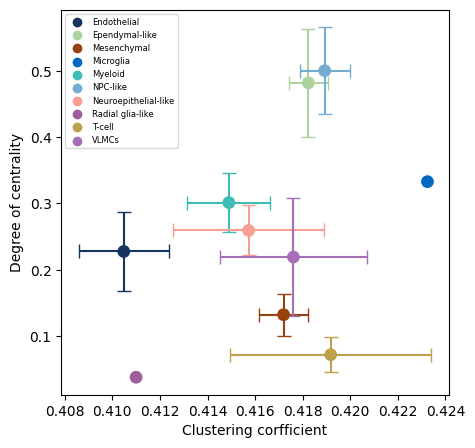

In [22]:
## Concatenate scores
dt = pd.concat(centralityScore_list)
## Calculated average and SEM
dt = dt.groupby(['Metaprogram'], as_index=False).agg({
    'degree_centrality': ['mean', 'sem'],
    'average_clustering': ['mean', 'sem'],
    'closeness_centrality': ['mean', 'sem']
})

dt.columns = ['Metaprogram', 
              'degree_centrality_mean', 'degree_centrality_sem', 
              'average_clustering_mean', 'average_clustering_sem', 
              'closeness_centrality_mean', 'closeness_centrality_sem']

## Scatter plot with error bars
plt.figure(figsize=(5, 5))
pt = sns.scatterplot(data=dt, x="average_clustering_mean", y="degree_centrality_mean", hue="Metaprogram", 
                     palette=metaprogram_to_color, legend = True, s = 100)
for i, row in dt.iterrows():
    plt.errorbar(x=row['average_clustering_mean'], y=row['degree_centrality_mean'], 
                  xerr=row['average_clustering_sem'], yerr=row['degree_centrality_sem'], 
                 fmt='o', capsize=5, color=metaprogram_to_color[row['Metaprogram']])


pt.set(xlabel = 'Clustering coefficient', ylabel = 'Degree of centrality')
pt.legend(fontsize = 6)
plt.savefig(directory+f"/1_centrality_scores_averages.pdf")
plt.show()

In [23]:
# Calculate neighborhood
nhood_list = []
for i in range(len(anndata_list)):
    sq.gr.nhood_enrichment(anndata_list[i], cluster_key = "Metaprogram", seed = 1234)
    
    df = pd.DataFrame(anndata_list[i].uns['Metaprogram_nhood_enrichment']['zscore'])
    df.index = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df.columns = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df['Programs'] = anndata_list[i].uns['Metaprogram_centrality_scores'].index
    df = pd.melt(df, id_vars='Metaprogram')
    
    nhood_list.append(df)


  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

In [36]:
## Averaging metrics
dt = pd.concat(nhood_list)
dt = dt.groupby(['Programs', 'variable'], as_index=False).agg({'value': 'mean'})
dt = dt.pivot(index='Programs', columns='variable')['value']
dt.to_csv(directory+f'2_neighborhood.csv')

In [24]:
nhood_list

[                Programs              variable       value
 0            Endothelial           Endothelial  243.385883
 1         Ependymal-like           Endothelial  -42.737673
 2                Myeloid           Endothelial    5.211920
 3               NPC-like           Endothelial  -79.036019
 4   Neuroepithelial-like           Endothelial  -97.332827
 5                 T-cell           Endothelial    3.218600
 6            Endothelial        Ependymal-like  -42.737673
 7         Ependymal-like        Ependymal-like  136.693294
 8                Myeloid        Ependymal-like    2.892415
 9               NPC-like        Ependymal-like   58.375129
 10  Neuroepithelial-like        Ependymal-like -116.717818
 11                T-cell        Ependymal-like    4.504631
 12           Endothelial               Myeloid    5.211920
 13        Ependymal-like               Myeloid    2.892415
 14               Myeloid               Myeloid   56.189708
 15              NPC-like               